In [5]:
important_families = ['lachnospiraceae', 'ruminococcaceae', 'rikenellaceae', 'porphyromonadaceae', 'prevotellaceae', 'bacteroidaceae', 'bifidobacteriaceae', 'coriobacteriaceae', 'veillonellaceae', 'clostridiaceae', 'enterobacteriaceae', 'streptococcaceae', 'peptostreptococcaceae', 'pasteurellaceae', 'acidaminococcaceae', 'verrucomicrobiaceae', 'desulfovibrionaceae', 'erysipelotrichaceae', 'sutterellaceae', 'victivallaceae']
len(important_families)

20

In [12]:
import gzip
from Bio import SeqIO
import re

# Function to load FASTA sequences and taxonomic annotations
def parse_data(fasta_file, taxonomy_file):
    sequences = []
    labels = []
    others_count = 0
    
    # Load taxonomy data into a dictionary for quick lookup
    taxonomy_dict = {}
    with gzip.open(taxonomy_file, 'rt') as f:
        for line in f:
            fields = line.strip().split('\t')
            accession = fields[0]
            taxonomy = fields[1]
            taxonomy_dict[accession] = taxonomy
    
    # Load sequences and labels
    with gzip.open(fasta_file, 'rt') as f:
        for record in SeqIO.parse(f, 'fasta'):
            accession = record.id
            if accession in taxonomy_dict:
                try:
                    family = re.search(r'f__([a-z]+)', taxonomy_dict[accession].lower()).group(1)
                except:
                    print('Error', taxonomy_dict[accession])
                    continue
                if family in important_families:
                    sequences.append(str(record.seq))
                    taxonomy = taxonomy_dict[accession]
                    labels.append(family)  # Extract family level taxonomy
                elif others_count < 50000:
                    sequences.append(str(record.seq))
                    taxonomy = taxonomy_dict[accession]
                    labels.append('others')
                    others_count += 1
    
    with open('sequences_small.txt', 'w') as f:
        for sequence, label in zip(sequences, labels):
            f.write(sequence + '\t' + label + '\n')

# Load data
fasta_file = 'gg_12_10.fasta.gz'
taxonomy_file = 'gg_12_10_taxonomy.txt.gz'
parse_data(fasta_file, taxonomy_file)

Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Proteobacteria; c__Deltaprot

In [13]:
from smart_open import open

class Dataset():
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename):
            sequence, label = line.strip().split('\t')
            yield sequence, label

    def __len__(self):
        return sum(1 for line in open(self.filename))
    
# Load data
filename = 'sequences_small.txt'
dataset = Dataset(filename)
len(dataset)

320304

In [14]:
import numpy as np
labels = [y for x, y in dataset]
keys, counts = np.unique(labels, return_counts=True)
for key, count in zip(keys, counts):
    print(key, count)

bacteroidaceae 25779
bifidobacteriaceae 947
clostridiaceae 21219
coriobacteriaceae 2132
desulfovibrionaceae 1882
enterobacteriaceae 28225
erysipelotrichaceae 3912
lachnospiraceae 55807
others 50000
pasteurellaceae 8778
peptostreptococcaceae 3292
porphyromonadaceae 7022
prevotellaceae 12501
rikenellaceae 1469
ruminococcaceae 27326
streptococcaceae 57411
veillonellaceae 10206
verrucomicrobiaceae 2311
victivallaceae 85


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def preprocessor(x):
    sequence, label = x
    return sequence

# Vectorize sequences
vectorizer = CountVectorizer(analyzer='char', ngram_range=(4, 4), preprocessor=preprocessor)
X = vectorizer.fit_transform(dataset)

In [16]:
X.shape

(320304, 6195)

In [17]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [19]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Predict on test set
y_pred = clf.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9962847910585223


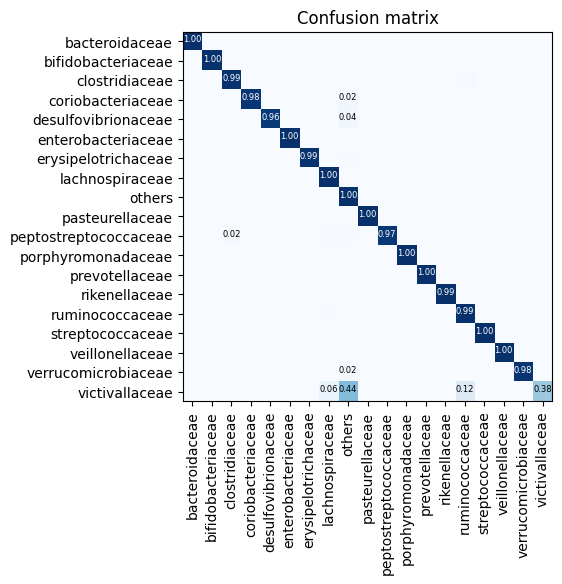

In [48]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
# Add values to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0.01:
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment='center', color='white' if cm[i, j] > 0.5 else 'black', fontsize=6)
# Add labels to confusion matrix
tick_marks = np.arange(len(clf.classes_))
plt.xticks(tick_marks, clf.classes_, rotation=90)
plt.yticks(tick_marks, clf.classes_)
plt.show()